# Word2Vec - SkipGram

Based on lab [notebook](https://github.com/aeau/MAU-AML-labs/blob/develop/2-language-models-lab/1-word2vec.ipynb) provided.


This notebook covers:
1. Skip-Gram Model

## Imports & Setup

In [2]:
import math
import torch
import torch.linalg
import matplotlib.pyplot as plt
import plotly.express as px
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Defining Helper functions 

In [3]:
def get_skip_grams(word_seq:list, context_size:int):
    vocab= []
    for i, token in enumerate(word_seq):
        for ci in range(-context_size, context_size+1):
            ii = ci + i
            if ii < 0 or ii >= len(word_seq) or ii == i:
                continue
            vocab.append(
                [token, word_seq[ii]]
            )
    return vocab


In [4]:
# testing function 

sentences = """the quick brown fox jumped over the lazy dog""".split()
word_sequence = " ".join(sentences).split()
win_size = 1

get_skip_grams(word_sequence, 2)[:5]

[['the', 'quick'],
 ['the', 'brown'],
 ['quick', 'the'],
 ['quick', 'brown'],
 ['quick', 'fox']]

## Defining Skip Gram Model 

In [5]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embeding_size, ):
        super(SkipGram, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embeding_size)
        self.W = nn.Linear(embeding_size, embeding_size, bias=False) 
        self.WT = nn.Linear(embeding_size, vocab_size, bias=False)
    
    def forward(self, x):
        x = self.embedding(x)
        x = self.W(x)
        x = F.relu(x)
        return self.WT(x)
    
    def get_embedding(self, word_index):
        wi = torch.tensor([word_index]).to(device)
        return self.embedding(wi).view(1,-1)
    


## Preping Data 

In [6]:
raw_text= """Long Short-Term Memory (LSTM) is a recurrent neural network (RNN) architecture that has been designed
to address the vanishing and exploding gradient problems of conventional RNNs. Unlike feedforward neural networks,
RNNs have cyclic connections making them powerful for modeling sequences. 
They have been successfully used for sequence labeling and sequence prediction tasks,
such as handwriting recognition, language modeling, phonetic labeling of acoustic frames. However, in contrast to the deep neural
networks, the use of RNNs in speech recognition has been limited to phone recognition in small scale tasks. 
In this paper, we present novel LSTM based RNN architectures which make more effective
use of model parameters to train acoustic models for large vocabulary speech recognition. 
We train and compare LSTM, RNN and DNN models at various numbers of parameters and configurations.
We show that LSTM models converge quickly and give state of the art speech recognition performance for relatively small sized models.""".split()

vocab = set(raw_text)
vocab_size = len(vocab)
word_to_index = {word: i for i, word in enumerate(vocab)}
index_to_word = {i: word for i, word in enumerate(vocab)}

print('num total words: ', len(raw_text))
print('Num unique words: ', vocab_size)

num total words:  152
Num unique words:  106


## Defining Hyperparameters 


In [7]:
CONTEXT_SIZE = 2
VOCAB_SIZE = vocab_size
EMBEDD_DIM = 10
BATCH_SIZE = 6

## Defining Training Function 

In [8]:
def train(model, epochs, data, optimizer, criterion):
    model.train()
    losses = []
    for _ in range(epochs):
        total_loss = 0
        for target, context in data:

            # Prepare inputs and targets
            context_idxs =  torch.tensor(word_to_index[context], dtype=torch.long).to(device)
            target_id = torch.tensor(word_to_index[target], dtype=torch.long).to(device)

            # Do not accumulate 
            model.zero_grad()

            # Step 3. Run the forward pass
            logits = model(context_idxs)

            # Step 4. Compute your loss function.
            loss = criterion(logits, target_id)


            # Step 5. Do the backward pass and update the gradient
            loss.backward()
            optimizer.step()

            # Get the Python number from a 1-element Tensor by calling tensor.item()
            total_loss += loss.item()
        losses.append(total_loss)
    return losses

In [9]:
dataset = get_skip_grams(raw_text, CONTEXT_SIZE)

model = SkipGram(VOCAB_SIZE, EMBEDD_DIM)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

model

SkipGram(
  (embedding): Embedding(106, 10)
  (W): Linear(in_features=10, out_features=10, bias=False)
  (WT): Linear(in_features=10, out_features=106, bias=False)
)

In [10]:
model.to(device)
losses = train(model, 100, dataset, optimizer, criterion)

In [11]:
fig = px.line(losses, title="Loss")
fig.update_layout(
    xaxis_title="Epoch",
    yaxis_title="Loss",)
fig.show()

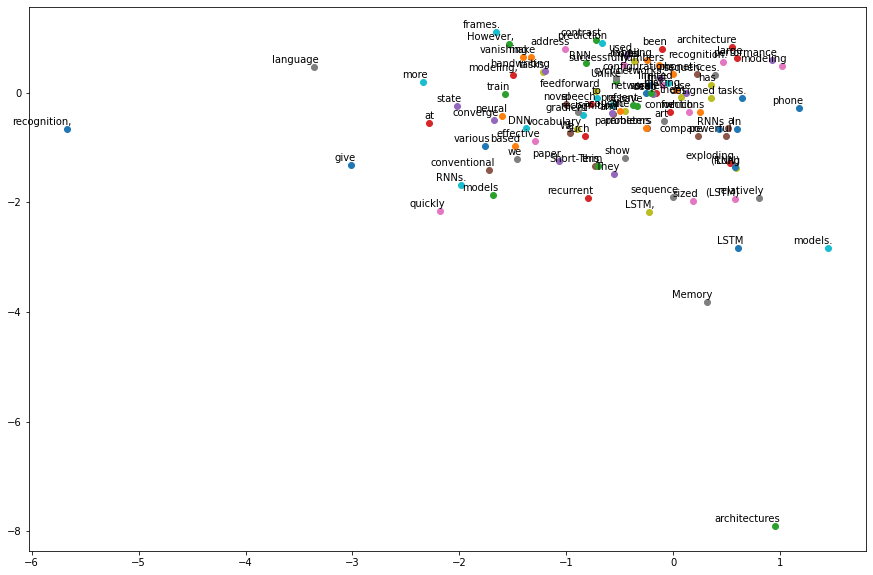

In [12]:
plt.figure(figsize=(15,10))
for w in vocab:
    x = model.get_embedding(word_to_index[w]).detach().data.cpu().numpy()[0][0]
    y = model.get_embedding(word_to_index[w]).detach().data.cpu().numpy()[0][1]
    plt.scatter(x, y)
    plt.annotate(w, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()

## Checking word similarity 

In [13]:
w = 'network'
w1_id = torch.tensor(word_to_index[w], dtype=torch.long)
wv_1 = model.get_embedding(w1_id)

w = 'neural'
w2_id = torch.tensor(word_to_index[w], dtype=torch.long)
wv_2 = model.get_embedding(w2_id)

word_distance = torch.linalg.norm(wv_1 - wv_2)
print("Distance", word_distance)
#

Distance tensor(2.4567, grad_fn=<LinalgVectorNormBackward0>)


In [14]:
word_similarity = (wv_1.view(-1).dot(wv_2.view(-1)) / (torch.linalg.norm(wv_1) * torch.linalg.norm(wv_2)))
print("Similarity", word_similarity)

Similarity tensor(0.3286, grad_fn=<DivBackward0>)


## Predicting context words

In [21]:
words = ['neural']

for i in range(0,5):
    next_word = index_to_word[torch.argmax(model(torch.tensor(word_to_index[words[-1]], dtype=torch.long).to(device))).item()]
    words.append(next_word)

' '.join(words)

'neural the recognition, modeling, language LSTM'